# scMeMo implementation scratch notebook

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
# warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/scmemo')
# sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/scmemo')
import scmemo, estimator, util, bootstrap

In [9]:
data_path = '/data/parameter_estimation/interferon_data/20200412/'
# data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/parameter_estimation_paper/interferon_04_25_2020/'

### Perform some basic filtering

In [37]:
def simplify_name(name):
    return name.split('.')[0]

In [216]:
# adata = sc.read(data_path + 'interferon_highcount.raw.h5ad')
adata = sc.read(data_path + 'interferon.h5ad')
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
adata.X = adata.X.astype(np.int64)
adata = adata[(adata.obs.cell != 'nan') & (adata.obs.multiplets=='singlet') & (adata.obs.cell.isin(cts))]
# adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [217]:
adata.X.dtype

dtype('int64')

In [218]:
# adata = sc.read(data_path + 'interferon.h5ad')
adata.obs['n_counts'] = adata.X.sum(axis=1)

adata.var['n_max'] = adata.X.max(axis=0).toarray()[0]
adata.var['n_cell'] = (adata.X > 0).sum(axis=0).A1



Trying to set attribute `.obs` of view, copying.


In [219]:
known_gene_df = pd.read_csv(data_path + 'chipseq/gene_locations_2.bed', header=0, sep='\t')#[[4, 5]]
known_gene_df['gene_name'] = known_gene_df['transcript'].apply(simplify_name)
known_gene_df['gene_ids'] = known_gene_df['protein'].apply(simplify_name)

In [220]:
new_var = adata.var.merge(known_gene_df, on='gene_ids', how='left')
new_var.index = adata.var.index
adata.var = new_var.copy()

In [221]:
adata.obs.cell.value_counts()

CD4 T cells          10389
CD14+ Monocytes      5385 
B cells              2573 
CD8 T cells          2042 
NK cells             1993 
FCGR3A+ Monocytes    1599 
Name: cell, dtype: int64

In [222]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


### Filtering

In [223]:
imp.reload(scmemo)
imp.reload(estimator)
imp.reload(util)
imp.reload(bootstrap)

<module 'bootstrap' from '/home/ssm-user/Github/scrna-parameter-estimation/scmemo/bootstrap.py'>

In [232]:
adata.shape

(23981, 35635)

In [235]:
adata1.shape

(23981, 35635)

In [245]:
imp.reload(estimator)
imp.reload(bootstrap)
imp.reload(scmemo)
imp.reload(util)
adata.X = adata.X.astype(np.int64)
adata1 = scmemo.create_groups(adata, label_columns=['stim', 'ind','cell'], inplace=False)
adata2 = scmemo.compute_1d_moments(adata1, inplace=False)

In [294]:
df = pd.DataFrame()
df['size_factor'] = adata2.uns['scmemo']['all_size_factor']
df['bin'] = pd.cut(df['size_factor'], bins=20)
mapping = df.groupby('bin')['size_factor'].median().reset_index(name='quantized_size_factor')
df = df.merge(mapping, on='bin')
counts = df.groupby('quantized_size_factor').size().reset_index(name='count')

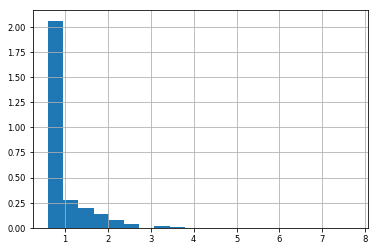

In [296]:
df['quantized_size_factor'].hist(bins=20, density=True);
# df['size_factor'].hist(bins=100, density=True);


In [259]:
df

,size_factor,bin,quantiazed_size_factor
0,1.965796,"(1.331, 7.698]",1.958160
1,1.616017,"(1.331, 7.698]",1.958160
2,2.227642,"(1.331, 7.698]",1.958160
3,1.789279,"(1.331, 7.698]",1.958160
4,1.404978,"(1.331, 7.698]",1.958160
...,...,...,...
23976,0.601854,"(0.597, 0.731]",0.664914
23977,0.715842,"(0.597, 0.731]",0.664914
23978,0.679366,"(0.597, 0.731]",0.664914
23979,0.672852,"(0.597, 0.731]",0.664914


In [258]:
adata.shape

(23981, 35635)

In [253]:
pd.qcut(adata2.uns['scmemo']['all_size_factor'], q=5)

[(1.331, 7.698], (1.331, 7.698], (0.366, 0.597], (1.331, 7.698], (0.898, 1.331], ..., (0.597, 0.731], (1.331, 7.698], (0.898, 1.331], (0.731, 0.898], (0.597, 0.731]]
Length: 23981
Categories (5, interval[float64]): [(0.366, 0.597] < (0.597, 0.731] < (0.731, 0.898] < (0.898, 1.331] < (1.331, 7.698]]

In [250]:
pd.Series().qcut(q=5)

AttributeError: 'Series' object has no attribute 'qcut'

In [239]:
len(adata2.uns['scmemo']['gene_list'])

1341

In [242]:
%%time
adata3 = scmemo.bootstrap_1d_moments(adata2, inplace=False, num_boot=10, verbose=True)

sg^ctrl^1016^CD14+ Monocytes
sg^ctrl^1256^CD14+ Monocytes
sg^ctrl^1488^CD4 T cells


KeyboardInterrupt: 

In [241]:
adata4 = scmemo.compute_2d_moments(adata3, gene_1=['STAT1', 'STAT3'], gene_2=['OAS1', 'OASL'], inplace=False)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
%%time
adata5 = scmemo.bootstrap_2d_moments(adata4, inplace=False, num_boot=5000)

In [204]:
np.mean([])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [206]:
imp.reload(scmemo)
imp.reload(estimator)
imp.reload(util)
imp.reload(bootstrap)

adata3 = scmemo.bootstrap_1d_moments(adata2, inplace=False, num_boot=5)

IndexError: index 5 is out of bounds for axis 0 with size 5

In [231]:
a, b, c = adata1.uns['scmemo']['1d_moments']['sg^CD14+ Monocytes']
a, b, c = adata1.uns['scmemo']['1d_moments']['sg^CD4 T cells']

In [232]:
cond = np.isfinite(np.log(a)) & np.isfinite(c)

In [233]:
stats.pearsonr(np.log(a)[cond], c[cond])

(0.03334066738682444, 0.19141418559197096)

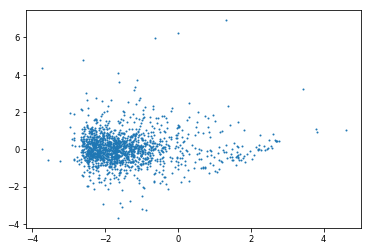

In [234]:
plt.scatter(np.log(a), c, s=1)

In [411]:
from sklearn import linear_model, preprocessing

In [455]:
m, v = adata2.uns['scmemo']['1d_moments']['sg^CD4 T cells']
m, v = np.log(m), np.log(v)
cond = np.isfinite(m) & np.isfinite(v)
m, v = m[cond], v[cond]

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [456]:
ransac = linear_model.RANSACRegressor().fit(m.reshape(-1, 1), v)
outliers = ~ransac.inlier_mask_
s, i, _, _, _ = stats.linregress(m, v)
res_v = v - ransac.predict(m.reshape(-1, 1))
res_v2 = v - (s*m+i)

In [465]:
a, b = [1, 2]

In [464]:
np.full(5, np.nan)

array([nan, nan, nan, nan, nan])

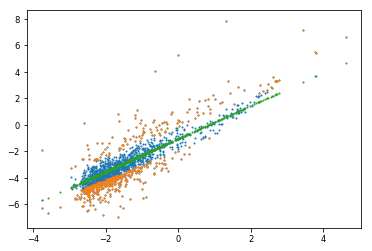

In [460]:
plt.scatter(m, v, s=1)
plt.scatter(m[outliers], v[outliers], s=1)
plt.scatter(m, ransac.predict(m.reshape(-1, 1)), s=1)

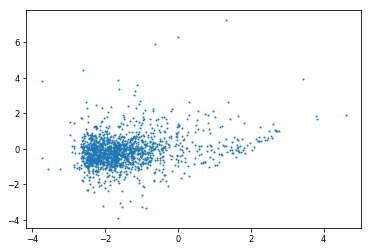

In [459]:
plt.scatter(m, res_v, s=1)
# plt.scatter(m, res_v2, s=1)

In [320]:
adata

AnnData object with n_obs × n_vars = 29065 × 35635 
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_counts'
    var: 'gene_ids', 'n_max', 'n_cell', '#chrom', 'chromStart', 'chromEnd', 'clusterId', 'transcript', 'protein', 'gene_name'
    obsm: 'X_tsne'

In [182]:
data = adata2.X.tocsc()

In [183]:
x = np.random.random(selected.shape[1])

In [252]:
def _sparse_bincount(col):
    """ Sparse bincount. """

    if col.data.shape[0] == 0:
        return np.array([col.shape[0]])
    counts = np.bincount(col.data)
    counts[0] = col.shape[0] - col.data.shape[0]
    print(col.shape[0])
    expr = np.arange(counts.shape[0])

    return expr[counts != 0], counts[counts != 0]

In [281]:
Nc, G = data.shape
num_permute = 100

for gene_idx in [0]:

    expr, counts = _sparse_bincount(data[:, gene_idx])
    gene_mult_rvs = stats.multinomial.rvs(n=Nc, p=counts/Nc, size=num_permute)
    
    

29065


In [300]:
selected = data[:, [0]]
x = np.random.random(selected.shape[1])
y = selected.dot(x)

In [301]:
%%time
a = data[:, 1].toarray()

CPU times: user 1.21 ms, sys: 293 µs, total: 1.5 ms
Wall time: 874 µs


In [313]:
%%time
a = data[:, 1].toarray()

CPU times: user 1.06 ms, sys: 257 µs, total: 1.31 ms
Wall time: 748 µs


In [312]:
a

<29065x1 sparse matrix of type '<class 'numpy.float64'>'
	with 6586 stored elements in Compressed Sparse Column format>

In [309]:
np.unique(a)

array([<29065x1 sparse matrix of type '<class 'numpy.float64'>'
	with 6586 stored elements in Compressed Sparse Column format>],
      dtype=object)

In [304]:
a

<29065x1 sparse matrix of type '<class 'numpy.longlong'>'
	with 6586 stored elements in Compressed Sparse Column format>

In [276]:
imp.reload(estimator)

<module 'estimator' from '/home/ssm-user/Github/scrna-parameter-estimation/scmemo/estimator.py'>

In [277]:
estimator._poisson_1d(data=data, n_obs=Nc)[0]

array([19.78228109,  0.2719422 ,  0.18300361, ...,  1.18974712,
        0.13665921,  0.23884397])

In [290]:
estimator._poisson_1d(data=(expr.reshape(-1, 1), gene_mult_rvs.T), n_obs=Nc)[0].mean()

19.848165835196973

In [288]:
(np.tile(expr.reshape(1, -1), (num_permute, 1))*gene_mult_rvs).T

array([[   0,    0,    0, ...,    0,    0,    0],
       [2695, 2615, 2619, ..., 2504, 2609, 2568],
       [2332, 2374, 2422, ..., 2504, 2576, 2412],
       ...,
       [ 394,    0,  788, ...,  394,  394,  394],
       [ 808,  404,  404, ...,    0, 1212,  404],
       [ 424,  424,  848, ...,  424,    0,    0]])

In [287]:
gene_mult_rvs.T*expr.reshape(-1,1)

array([[   0,    0,    0, ...,    0,    0,    0],
       [2695, 2615, 2619, ..., 2504, 2609, 2568],
       [2332, 2374, 2422, ..., 2504, 2576, 2412],
       ...,
       [ 394,    0,  788, ...,  394,  394,  394],
       [ 808,  404,  404, ...,    0, 1212,  404],
       [ 424,  424,  848, ...,  424,    0,    0]])

In [261]:
expr*gene_mult_rvs

array([[   0, 2635, 2296, ...,  394,  808,  848],
       [   0, 2580, 2406, ...,    0,  404,    0],
       [   0, 2533, 2356, ...,  394,    0,    0],
       ...,
       [   0, 2572, 2422, ...,  394,  404,    0],
       [   0, 2506, 2440, ...,  394,    0, 1272],
       [   0, 2601, 2426, ...,  394,  404,    0]])

In [260]:
gene_mult_rvs.shape

(100, 326)

In [258]:
expr.shape

(326,)

In [241]:
%%time
temp = _sparse_bincount(data[:, 0])

CPU times: user 802 µs, sys: 0 ns, total: 802 µs
Wall time: 533 µs


In [305]:
%%time
selected = data[:, [0, 2]]
x = np.random.random(selected.shape[1])
y = selected.dot(x)
_, index, count_1 = np.unique(y, return_counts=True, return_index=True)
expr_1 = selected[index]

CPU times: user 3.11 ms, sys: 0 ns, total: 3.11 ms
Wall time: 2.51 ms


In [229]:
%%time
selected = data[:, [0, 2]].toarray()
expr_2, count_2 = np.unique(selected, return_counts=True, axis=0)

CPU times: user 16.1 ms, sys: 0 ns, total: 16.1 ms
Wall time: 15.4 ms


In [96]:
data = adata.X

In [97]:
selected = data[:, [0, 2]].toarray()

In [100]:
selected[:, [0]]

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [230]:
count_1.sum()

29065

In [231]:
count_2.sum()

29065

In [232]:
set(count_2) == set(count_1)

True

In [233]:
expr_2.shape

(663, 2)

In [236]:
expr_2

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ...,
       [394,   0],
       [404,   0],
       [424,   0]], dtype=int64)

In [235]:
expr_1.toarray()

array([[  0,   0],
       [  1,   0],
       [  0,   1],
       ...,
       [394,   0],
       [404,   0],
       [424,   0]], dtype=int64)

In [196]:
%%time
selected.dot(x)

CPU times: user 1.05 ms, sys: 0 ns, total: 1.05 ms
Wall time: 503 µs


array([0.        , 0.        , 0.        , ..., 2.62061451, 5.24122901,
       1.96546088])

In [180]:
data[:, 0].multiply(data[:, 0])

<29065x1 sparse matrix of type '<class 'numpy.int64'>'
	with 17561 stored elements in Compressed Sparse Column format>

In [179]:
dir(data)

['__abs__',
 '__add__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__idiv__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmatmul__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_add_dense',
 '_add_sparse',
 '_arg_min_or_max',
 '_arg_min_or_max_axis',
 '_asindices',
 '_binopt',
 '_cs_matrix__get_has_canonical_format',
 '_cs_matrix__get_sorted',
 '_cs_matrix__set_has_canonical_format',
 '_cs_

In [176]:
%%time
selected = data[:, [0, 2]].toarray()

CPU times: user 878 µs, sys: 209 µs, total: 1.09 ms
Wall time: 662 µs


In [172]:
selected

<19352x2 sparse matrix of type '<class 'numpy.longlong'>'
	with 22132 stored elements in Compressed Sparse Column format>

In [162]:
selected

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [156]:
selected

<29065x2 sparse matrix of type '<class 'numpy.longlong'>'
	with 0 stored elements in Compressed Sparse Row format>

In [141]:
adata1

AnnData object with n_obs × n_vars = 29065 × 35635 
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_counts', 'scmemo_group'
    var: 'gene_ids', 'n_max', 'n_cell', '#chrom', 'chromStart', 'chromEnd', 'clusterId', 'transcript', 'protein', 'gene_name'
    uns: 'scmemo'
    obsm: 'X_tsne'

In [142]:
adata2

AnnData object with n_obs × n_vars = 29065 × 1435 
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_counts', 'scmemo_group'
    var: 'gene_ids', 'n_max', 'n_cell', '#chrom', 'chromStart', 'chromEnd', 'clusterId', 'transcript', 'protein', 'gene_name'
    uns: 'scmemo'
    obsm: 'X_tsne'